In [1]:
# Import modules
import os
import math
import time
import scipy
import numpy as np
import cv2
import zipfile
import urllib.request
import shutil
import sys

from PIL import Image
from skimage import draw
import random
import skimage
import matplotlib.pyplot as plt

# Local modules
# Local modules
sys_mrcc_module = 'c:\\program files\\python36\\lib\\site-packages\\mask_rcnn-2.1-py3.6.egg'
if sys_mrcc_module in sys.path:
    sys.path.remove(sys_mrcc_module)
sys.path.append(os.getcwd())
print(sys.path)
import mrcnn
import mrcnn.visualize as visualize
import mrcnn.utils as utils
import mrcnn.model as modellib
import dicastalxray
from dicastalxray import TrainConfig
from dicastalxray import XrayDataset
print(modellib.__file__)
print(dicastalxray.__file__)


# Related directories
ROOT_DIR = os.getcwd()
MODEL_DIR = ROOT_DIR
DATASET_DIR = os.path.join(ROOT_DIR, "datasets", "defects_1_processed_renamed")

# Path to trained weights file (COCO)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
assert os.path.exists(COCO_MODEL_PATH)

# Classes
BACKGROUND_CLASS = 0
CASTING_DEFECT = 1

# These layers change weights depending on the number of classes
EXCLUDE_LAYER_WEIGHTS = [
    'mrcnn_bbox_fc',      # [1024,324]  --> [1024,8]
    'mrcnn_class_logits', # [1024,2]    --> [1024,81]
    'mrcnn_mask',         # [1,1,256,2] --> [1,1,256,81]
]


['c:\\program files\\python36\\python36.zip', 'c:\\program files\\python36\\DLLs', 'c:\\program files\\python36\\lib', 'c:\\program files\\python36', '', 'C:\\Users\\jun\\AppData\\Roaming\\Python\\Python36\\site-packages', 'c:\\program files\\python36\\lib\\site-packages', 'c:\\program files\\python36\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\jun\\.ipython', 'C:\\Users\\jun\\OneDrive\\work\\tensorFlow\\project\\casting_defect_localization_dicastal']
C:\Users\jun\OneDrive\work\tensorFlow\project\casting_defect_localization_dicastal\mrcnn\model.py
C:\Users\jun\OneDrive\work\tensorFlow\project\casting_defect_localization_dicastal\mask_rcnn_coco.h5
C:\Users\jun\OneDrive\work\tensorFlow\project\casting_defect_localization_dicastal\mrcnn\model.py
C:\Users\jun\OneDrive\work\tensorFlow\project\casting_defect_localization_dicastal\dicastalxray.py


Using TensorFlow backend.


In [2]:
# Notebook preference
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
class InferenceConfig(TrainConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    
    RPN_NMS_THRESHOLD = 0.9

In [4]:
# Dataset for validation
dataset_val = XrayDataset()
dataset_val.load_dicastalxray(dataset_dir=DATASET_DIR, subset="validation")
dataset_val.prepare()

print("data preparation finished")

C:\Users\jun\OneDrive\work\tensorFlow\project\casting_defect_localization_dicastal\datasets\defects_1_processed_renamed\..\annotation_filenames_validation.csv
Adding image: 4.bmp
Adding image: 10.bmp
Adding image: 13.bmp
Adding image: 15.bmp
Adding image: 17.bmp
Adding image: 90.bmp
Adding image: 117.bmp
Adding image: 118.bmp
Adding image: 123.bmp
Adding image: 138.bmp
Adding image: 145.bmp
Adding image: 155.bmp
Adding image: 163.bmp
Adding image: 164.bmp
Adding image: 174.bmp
Adding image: 180.bmp
Adding image: 186.bmp
Adding image: 195.bmp
Adding image: 206.bmp
Adding image: 210.bmp
Adding image: 216.bmp
Adding image: 231.bmp
Adding image: 259.bmp
Adding image: 262.bmp
Adding image: 280.bmp
Adding image: 287.bmp
Adding image: 329.bmp
Adding image: 330.bmp
Adding image: 346.bmp
Adding image: 347.bmp
Adding image: 367.bmp
Adding image: 400.bmp
Adding image: 409.bmp
Adding image: 410.bmp
Adding image: 424.bmp
Adding image: 425.bmp
Adding image: 437.bmp
Adding image: 440.bmp
Adding image

In [5]:
inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_weights_path = os.path.join(MODEL_DIR,"dicastalxray20190511T1706","mask_rcnn_dicastalxray_0018.h5")
model.load_weights(model_weights_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Re-starting from epoch 18


# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_val.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

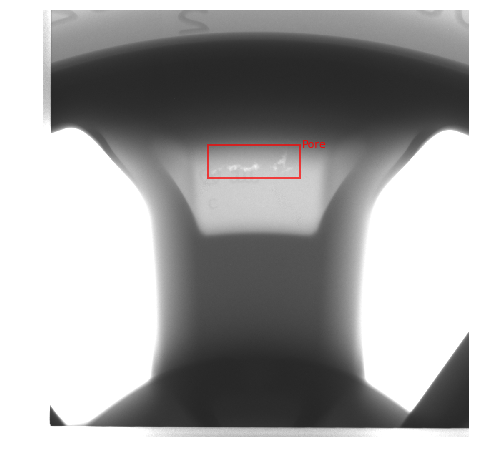

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


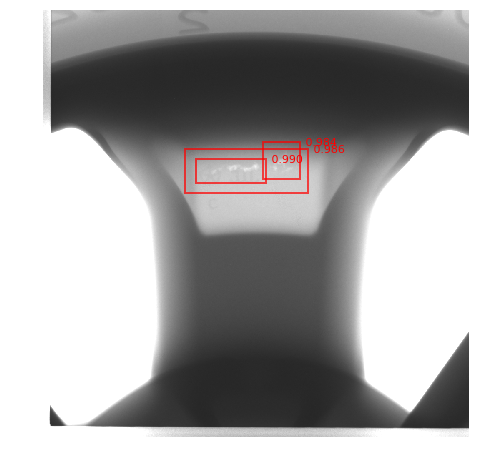

In [6]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config,
                           image_id, use_mini_mask=False)


ax1 = visualize.display_boxes_jun(original_image, gt_bbox, gt_class_id,
                            dataset_val.class_names, ax=get_ax())
#ax1 = visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
#                            dataset_val.class_names, ax=get_ax())


results = model.detect([original_image], verbose=1)

r = results[0]
ax2 = visualize.display_boxes_jun(original_image, r['rois'], r['class_ids'], 
                            ['BG', ''], r['scores'], score_range=[0.92,1],ax=get_ax())
#ax2 = visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
#                            ['BG', ''], r['scores'], ax=get_ax())

In [7]:
print(dataset_val.class_names)

['BG', 'Pore']


In [8]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.49083333333333334


19.51.59P443258W188V2I1A6S0M0N00314c35R1E0Othund.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


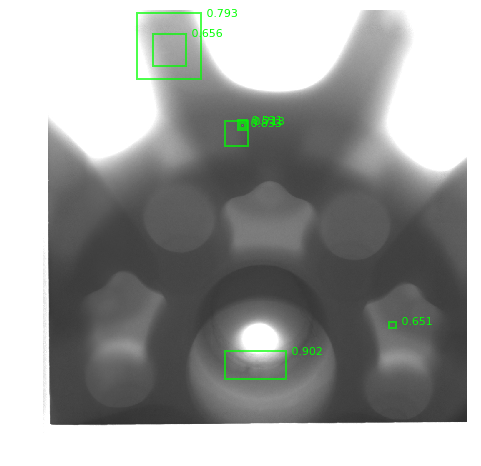

In [9]:
img_dicastal_dir = os.path.join(MODEL_DIR, "original_files", "defect_20190505","for_test")
files = next(os.walk(img_dicastal_dir))[2]
img_dicastal_basename = random.choice(files)
print(img_dicastal_basename)
fig_dicastal = cv2.imread(os.path.join(img_dicastal_dir,img_dicastal_basename))                     

results = model.detect([fig_dicastal], verbose=1)

r = results[0]
#visualize.display_instances(fig_dicastal, r['rois'], r['masks'], r['class_ids'], 
#                            dataset_val.class_names, r['scores'], ax=get_ax())
#visualize.display_top_masks(fig_dicastal, r['masks'], r['class_ids'], 
#                            dataset_val.class_names)
ax2 = visualize.display_boxes_jun(fig_dicastal, r['rois'], r['class_ids'], 
                            ['BG', ''], r['scores'], score_range=[0.92,1],ax=get_ax())